In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from transformers import ViTFeatureExtractor

model_ckpt = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [3]:
images_root = 'Affectnet/Manually_Annotated/Manually_Annotated_Images'

In [4]:
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import os


def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class AffectNetDataset(Dataset):
    def __init__(self,
                 csvfile,
                 root,
                 mode='classification',
                 crop=False,
                 transform=None,
                 invalid_files=None):
        assert mode in ('valence', 'arousal', 'valence-arousal')
        self.df = pd.read_csv(csvfile)
        self.root = root
        self.mode = mode
        self.crop = crop
        self.transform = transform
        self.invalid_files = invalid_files
        
        if self.invalid_files:
            self.df = self.df[~self.df['subDirectory_filePath'].isin(invalid_files)]
            self.df = self.df
        
        self.df = self.df[~((self.df['expression'] == 9) | (self.df['expression'] == 10))].reset_index(drop=True)
    
    def __getitem__(self, idx):
        try:
            img = pil_loader(os.path.join(self.root, self.df['subDirectory_filePath'][idx]))
        except KeyError:
            raise IndexError
        if self.crop:
            img = img.crop((self.df['face_x'][idx],
                            self.df['face_y'][idx],
                            self.df['face_x'][idx]+self.df['face_width'][idx],
                            self.df['face_y'][idx]+self.df['face_height'][idx],))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'classification':
            target = torch.tensor(self.df['expression'][idx])
        elif self.mode == 'valence':
            target = torch.tensor([self.df['valence'][idx]])
        elif self.mode == 'arousal':
            target = torch.tensor([self.df['arousal'][idx]])
        else:
            target = torch.tensor([self.df['valence'][idx],
                                   self.df['arousal'][idx]])
        return img.float(), target.float()
    
    def __len__(self):
        return len(self.df)

In [5]:
def collate_fn(examples):
    imgs, targets = zip(*examples)
    pixel_values = torch.stack(imgs)
    targets = torch.stack(targets)
    return {'pixel_values': pixel_values, 'labels': targets}

In [6]:
train_invalid_files = ['103/29a31ebf1567693f4644c8ba3476ca9a72ee07fe67a5860d98707a0a.jpg']
val_invalid_files = []

In [7]:
mode = 'valence'
seed = 0

In [8]:
from torchvision.transforms import (Compose,
                                    Normalize,
                                    Resize,
                                    ToTensor)
from torch.utils.data import random_split


normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transform = Compose([Resize(tuple(feature_extractor.size.values())),
                     ToTensor()])

train_dataset = AffectNetDataset('Affectnet/training.csv',
                                 images_root,
                                 mode,
                                 crop=False,
                                 transform=transform,
                                 invalid_files=train_invalid_files)

val_dataset = AffectNetDataset('Affectnet/validation.csv',
                               images_root,
                               mode,
                               crop=False,
                               transform=transform,
                               invalid_files=val_invalid_files)

print('train:', len(train_dataset))
print('validation:', len(val_dataset))


train: 320739
validation: 4500


訓練データの分布をカーネル密度推定により平滑化し，MSEに重みづけする

In [9]:
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.modules.loss import _Loss
from scipy.stats import gaussian_kde

class KDEWeightLoss(_Loss):
    def __init__(self, dataset, mode, bw_method=None, eps=1e-6, device=None):
        super(KDEWeightLoss, self).__init__()
        assert mode in ('valence', 'arousal', 'valence-arousal')
        self.mode = mode
        self.bw_method = bw_method
        self.eps = eps
        self.device = device
        self.kernel = self._calc_kernel(dataset.df)
    
    def forward(self, pred, target):
        loss = torch.mean(torch.dot(torch.tensor(1 / (self.kernel(target.cpu().T) + self.eps)).float().to(self.device),
                                    ((pred - target) ** 2).sum(1)))
        return loss
    
    def _calc_kernel(self, df):
        if self.mode == 'arousal':
            data = df[self.mode].to_numpy().T
        elif self.mode == 'valence':
            data = df[self.mode].to_numpy().T
        else:
            data = df[['valence', 'arousal']].to_numpy().T
        return gaussian_kde(data, bw_method=self.bw_method)

In [10]:
from transformers import Trainer
import wandb

class KDEWeightLossTrainer(Trainer):
    def __init__(self,
                 model = None,
                 args = None,
                 data_collator = None,
                 train_dataset = None,
                 eval_dataset = None,
                 tokenizer = None,
                 model_init = None,
                 compute_metrics = None,
                 callbacks = None,
                 optimizers = (None, None),
                 preprocess_logits_for_metrics = None):
        super().__init__(model, args, data_collator, train_dataset, eval_dataset, tokenizer, model_init, compute_metrics, callbacks, optimizers, preprocess_logits_for_metrics)
        self.loss_fct = KDEWeightLoss(dataset=train_dataset,
                                      mode=mode,
                                      bw_method=0.2,
                                      device=self.args.device).to(self.args.device)
        self.mse = nn.MSELoss()
    
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss = self.loss_fct(logits, labels)
        mse = self.mse(logits, labels)
        rmse = torch.sqrt(mse)
        wandb.log({'train/mse': mse, 'train/rmse': rmse})
        return (loss, outputs) if return_outputs else loss

In [15]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=1,
                                                  problem_type='regression')


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments
import wandb

wandb.init(project='AffectNet-vit', name='KDE-val', id='kde_val_230403')

args = TrainingArguments(
    f"affectnet-kde-val",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=1e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=30,
    weight_decay=1e-3,
    load_best_model_at_end=True,
    logging_dir='logs',
    remove_unused_columns=False,
    report_to='wandb'
)

In [11]:
from sklearn.metrics import mean_squared_error
import numpy as np

def compute_metrics(eval_pred):
    preds, targets = eval_pred
    mse = mean_squared_error(targets, preds, squared=True) / 2
    rmse = np.sqrt(mse)
    return {'mse': mse, 'rmse': rmse}

In [ ]:
from transformers import EarlyStoppingCallback

trainer = KDEWeightLossTrainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [15]:
trainer.train()

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 500/300720 [08:50<84:38:03,  1.01s/it] 

{'loss': 17.7043, 'learning_rate': 9.98337323756318e-07, 'epoch': 0.05}


  0%|          | 1000/300720 [17:34<87:00:21,  1.05s/it]

{'loss': 12.0832, 'learning_rate': 9.966746475126364e-07, 'epoch': 0.1}


  0%|          | 1500/300720 [26:25<86:36:35,  1.04s/it] 

{'loss': 10.3867, 'learning_rate': 9.950119712689545e-07, 'epoch': 0.15}


  1%|          | 2000/300720 [35:17<85:19:15,  1.03s/it] 

{'loss': 9.6976, 'learning_rate': 9.933492950252726e-07, 'epoch': 0.2}


  1%|          | 2500/300720 [44:06<88:22:13,  1.07s/it] 

{'loss': 9.4008, 'learning_rate': 9.916866187815907e-07, 'epoch': 0.25}


  1%|          | 3000/300720 [52:59<89:22:44,  1.08s/it] 

{'loss': 9.0734, 'learning_rate': 9.90023942537909e-07, 'epoch': 0.3}


  1%|          | 3500/300720 [1:01:53<86:57:24,  1.05s/it]

{'loss': 8.4665, 'learning_rate': 9.88361266294227e-07, 'epoch': 0.35}


  1%|▏         | 4000/300720 [1:10:45<89:10:40,  1.08s/it] 

{'loss': 8.5017, 'learning_rate': 9.866985900505454e-07, 'epoch': 0.4}


  1%|▏         | 4500/300720 [1:19:37<86:07:43,  1.05s/it]

{'loss': 8.5554, 'learning_rate': 9.850359138068635e-07, 'epoch': 0.45}


  2%|▏         | 5000/300720 [1:28:32<88:07:21,  1.07s/it] 

{'loss': 8.2589, 'learning_rate': 9.833732375631816e-07, 'epoch': 0.5}


  2%|▏         | 5500/300720 [1:37:21<82:11:51,  1.00s/it]

{'loss': 8.2, 'learning_rate': 9.817105613194997e-07, 'epoch': 0.55}


  2%|▏         | 6000/300720 [1:46:15<82:48:58,  1.01s/it]

{'loss': 7.7236, 'learning_rate': 9.80047885075818e-07, 'epoch': 0.6}


  2%|▏         | 6500/300720 [1:55:08<86:23:26,  1.06s/it]

{'loss': 7.95, 'learning_rate': 9.783852088321361e-07, 'epoch': 0.65}


  2%|▏         | 7000/300720 [2:04:02<86:51:33,  1.06s/it]

{'loss': 7.6402, 'learning_rate': 9.767225325884544e-07, 'epoch': 0.7}


  2%|▏         | 7500/300720 [2:12:57<84:03:38,  1.03s/it]

{'loss': 7.9256, 'learning_rate': 9.750598563447725e-07, 'epoch': 0.75}


  3%|▎         | 8000/300720 [2:21:48<86:31:38,  1.06s/it] 

{'loss': 7.8371, 'learning_rate': 9.733971801010906e-07, 'epoch': 0.8}


  3%|▎         | 8500/300720 [2:30:43<86:06:57,  1.06s/it]

{'loss': 7.5264, 'learning_rate': 9.71734503857409e-07, 'epoch': 0.85}


  3%|▎         | 9000/300720 [2:39:40<85:17:06,  1.05s/it]

{'loss': 7.6686, 'learning_rate': 9.70071827613727e-07, 'epoch': 0.9}


  3%|▎         | 9500/300720 [2:48:32<85:04:22,  1.05s/it]

{'loss': 7.5344, 'learning_rate': 9.684091513700452e-07, 'epoch': 0.95}


  3%|▎         | 10000/300720 [2:57:29<84:38:04,  1.05s/it]

{'loss': 7.5887, 'learning_rate': 9.667464751263633e-07, 'epoch': 1.0}


                                                           
  3%|▎         | 10024/300720 [2:59:45<69:59:43,  1.15it/s]

{'eval_loss': 8.161540985107422, 'eval_mse': 0.08596639335155487, 'eval_rmse': 0.29320026151344897, 'eval_runtime': 111.023, 'eval_samples_per_second': 40.532, 'eval_steps_per_second': 2.54, 'epoch': 1.0}


  3%|▎         | 10500/300720 [3:08:03<82:28:47,  1.02s/it]  

{'loss': 7.4288, 'learning_rate': 9.650837988826816e-07, 'epoch': 1.05}


  4%|▎         | 11000/300720 [3:16:46<79:43:20,  1.01it/s]

{'loss': 7.1929, 'learning_rate': 9.634211226389997e-07, 'epoch': 1.1}


  4%|▍         | 11500/300720 [3:25:39<84:30:45,  1.05s/it]

{'loss': 7.4175, 'learning_rate': 9.61758446395318e-07, 'epoch': 1.15}


  4%|▍         | 12000/300720 [3:34:34<86:16:46,  1.08s/it] 

{'loss': 7.0848, 'learning_rate': 9.60095770151636e-07, 'epoch': 1.2}


  4%|▍         | 12500/300720 [3:43:31<86:41:37,  1.08s/it]

{'loss': 7.0388, 'learning_rate': 9.584330939079542e-07, 'epoch': 1.25}


  4%|▍         | 13000/300720 [3:52:28<82:32:15,  1.03s/it] 

{'loss': 7.0078, 'learning_rate': 9.567704176642723e-07, 'epoch': 1.3}


  4%|▍         | 13500/300720 [4:01:28<83:26:53,  1.05s/it]

{'loss': 7.269, 'learning_rate': 9.551077414205906e-07, 'epoch': 1.35}


  5%|▍         | 14000/300720 [4:10:24<84:18:51,  1.06s/it] 

{'loss': 6.878, 'learning_rate': 9.534450651769087e-07, 'epoch': 1.4}


  5%|▍         | 14500/300720 [4:19:18<84:26:40,  1.06s/it]

{'loss': 6.9193, 'learning_rate': 9.517823889332269e-07, 'epoch': 1.45}


  5%|▍         | 15000/300720 [4:28:12<87:54:46,  1.11s/it] 

{'loss': 7.1351, 'learning_rate': 9.50119712689545e-07, 'epoch': 1.5}


  5%|▌         | 15500/300720 [4:37:02<84:21:27,  1.06s/it]

{'loss': 7.0085, 'learning_rate': 9.484570364458632e-07, 'epoch': 1.55}


  5%|▌         | 16000/300720 [4:45:42<72:22:42,  1.09it/s] 

{'loss': 7.0913, 'learning_rate': 9.467943602021814e-07, 'epoch': 1.6}


  5%|▌         | 16085/300720 [4:47:10<82:01:51,  1.04s/it]

KeyboardInterrupt: 

In [13]:
from transformers import TrainingArguments

wandb.init(project='AffectNet-vit', id='kde_val_230403', resume='must')

args_ = TrainingArguments(
    f"affectnet-kde-val",
    evaluation_strategy="steps",
    eval_steps=1000,
    save_strategy='steps',
    save_steps=1000,
    learning_rate=1e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=30,
    weight_decay=1e-3,
    load_best_model_at_end=True,
    logging_dir='logs',
    remove_unused_columns=False,
    report_to='wandb'
)

eval/loss,8.16154
eval/mse,0.08597
eval/rmse,0.2932
eval/runtime,111.023
eval/samples_per_second,40.532
eval/steps_per_second,2.54
train/epoch,1.6
train/global_step,16000
train/learning_rate,0.0
train/loss,7.0913
train/mse,0.08174


In [17]:
from transformers import EarlyStoppingCallback

trainer = KDEWeightLossTrainer(
    model,
    args_,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.05)]
)

In [18]:
trainer.train(resume_from_checkpoint='affectnet-kde-val/checkpoint-16085')

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Skipping the first batches: 100%|██████████| 691/691 [03:42<00:00,  3.11it/s]

                                                     

{'loss': 6.8609, 'learning_rate': 9.989724660814047e-07, 'epoch': 0.1}


{'eval_loss': 8.27010726928711, 'eval_mse': 0.08505864441394806, 'eval_rmse': 0.2916481517410115, 'eval_runtime': 113.6787, 'eval_samples_per_second': 39.585, 'eval_steps_per_second': 2.481, 'epoch': 0.1}


{'loss': 6.8006, 'learning_rate': 9.973097898377228e-07, 'epoch': 0.15}


{'loss': 6.9157, 'learning_rate': 9.956471135940409e-07, 'epoch': 0.2}


{'eval_loss': 7.86115026473999, 'eval_mse': 0.08322253078222275, 'eval_rmse': 0.2884831551100042, 'eval_runtime': 111.9512, 'eval_samples_per_second': 40.196, 'eval_steps_per_second': 2.519, 'epoch': 0.2}


{'loss': 6.9577, 'learning_rate': 9.93984437350359e-07, 'epoch': 0.25}


{'loss': 6.994, 'learning_rate': 9.923217611066773e-07, 'epoch': 0.3}


{'eval_loss': 8.225268363952637, 'eval_mse': 0.08530547469854355, 'eval_rmse': 0.29207100968521943, 'eval_runtime': 51.7671, 'eval_samples_per_second': 86.928, 'eval_steps_per_second': 5.447, 'epoch': 0.3}


{'loss': 6.5922, 'learning_rate': 9.906590848629954e-07, 'epoch': 0.35}


{'loss': 6.7396, 'learning_rate': 9.889964086193135e-07, 'epoch': 0.4}


{'eval_loss': 7.72930908203125, 'eval_mse': 0.08224551379680634, 'eval_rmse': 0.2867847865504834, 'eval_runtime': 46.0708, 'eval_samples_per_second': 97.676, 'eval_steps_per_second': 6.121, 'epoch': 0.4}


{'loss': 7.0679, 'learning_rate': 9.873337323756318e-07, 'epoch': 0.45}


{'loss': 6.6904, 'learning_rate': 9.8567105613195e-07, 'epoch': 0.5}


{'eval_loss': 8.744487762451172, 'eval_mse': 0.08909215778112411, 'eval_rmse': 0.298483094632048, 'eval_runtime': 45.9366, 'eval_samples_per_second': 97.961, 'eval_steps_per_second': 6.139, 'epoch': 0.5}


{'loss': 6.7443, 'learning_rate': 9.84008379888268e-07, 'epoch': 0.55}


{'loss': 6.4389, 'learning_rate': 9.823457036445863e-07, 'epoch': 0.6}


{'eval_loss': 8.156037330627441, 'eval_mse': 0.08538579940795898, 'eval_rmse': 0.29220848620113515, 'eval_runtime': 46.1619, 'eval_samples_per_second': 97.483, 'eval_steps_per_second': 6.109, 'epoch': 0.6}



  2%|▏         | 6000/300720 [1:46:35<87:15:34,  1.07s/it]

{'train_runtime': 6395.2438, 'train_samples_per_second': 1504.582, 'train_steps_per_second': 47.022, 'train_loss': 6.015120646158854, 'epoch': 0.6}


TrainOutput(global_step=6000, training_loss=6.015120646158854, metrics={'train_runtime': 6395.2438, 'train_samples_per_second': 1504.582, 'train_steps_per_second': 47.022, 'train_loss': 6.015120646158854, 'epoch': 0.6})

In [19]:
trainer.save_state()
trainer.save_model()
wandb.finish()

eval/loss,▅▂▄▁█▄
eval/mse,▄▂▄▁█▄
eval/rmse,▄▂▄▁█▄
eval/runtime,██▂▁▁▁
eval/samples_per_second,▁▁▇███
eval/steps_per_second,▁▁▇███
train/epoch,▁▁▂▂▂▃▄▄▄▅▅▆▇▇▇███
train/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
train/learning_rate,█▇▇▆▅▄▄▃▂▂▁
train/loss,▆▅▆▇▇▃▄█▄▄▁
train/mse,▂▃▂▄▁▁▁▂▂▂▂▂▂▂▃▂▃▂▃▃▃▂▃▁▂▂▃▂▂▃▂▃█▂▂▂▁▂▇▃


In [9]:
from tqdm import tqdm

def CLE_tokens(model, tokenizer, dataset, device):
    tokens = []
    labels = []
    for img, label in tqdm(dataset):
        feature = tokenizer(img, return_tensors='pt').pixel_values.to(device)
        with torch.no_grad():
            token = model(feature, output_hidden_states=True).hidden_states[-1][0,0,:]
        tokens.append(token.cpu())
        labels.append(label)
    return torch.stack(tokens).squeeze(), torch.stack(labels)

In [10]:
from umap import UMAP
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

def plot_tokens(tokens, targets, n_neighbors):
    fig = plt.figure()
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    umap = UMAP(n_neighbors=n_neighbors)
    xy = np.array(umap.fit_transform(tokens.numpy()))
    x = xy[:, 0]
    y = xy[:, 1]
    z = targets
    ax = fig.add_subplot()
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('feature-1')
    ax.set_ylabel('feature-2')
    ax.set_title('valence')
    mp = ax.scatter(x, y,
                    alpha=1,
                    c=z,
                    cmap='Oranges',
                    vmin=-1,
                    vmax=1,
                    s=3)
    fig.colorbar(mp, ax=ax)
    plt.show()
    return fig


In [13]:
from transformers import ViTForImageClassification
model = ViTForImageClassification.from_pretrained('affectnet-kde-val',
                                                  num_labels=1,
                                                  problem_type='regression').to(device)

In [14]:
tokens, targets = CLE_tokens(model,
                             feature_extractor,
                             val_dataset,
                             device)
print(tokens.shape, targets.shape)

100%|██████████| 4500/4500 [02:07<00:00, 35.38it/s]

torch.Size([4500, 768]) torch.Size([4500, 1])


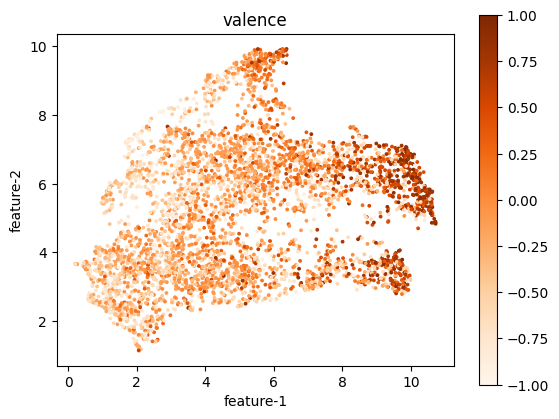

In [15]:
finetuned_fig = plot_tokens(tokens, targets, 10)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rkn. Use `wandb login --relogin` to force relogin


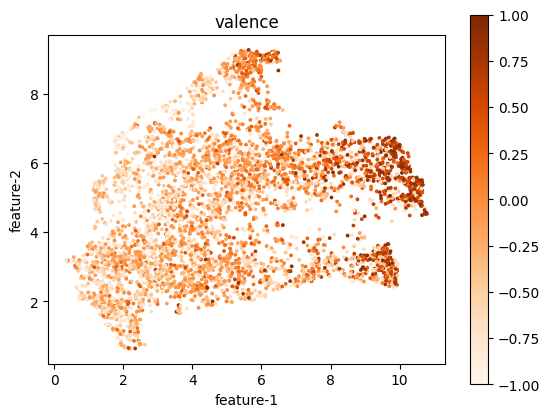

In [17]:
import wandb
wandb.init(project='AffectNet-vit', id='kde_val_230403', resume='must')
finetuned_fig = plot_tokens(tokens, targets, 10)
wandb.log({'finetuned-plot': wandb.Image(finetuned_fig)})

In [18]:
non_finetuned_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                                num_labels=1,
                                                                problem_type='regression').to(device)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


100%|██████████| 4500/4500 [05:47<00:00, 12.96it/s]


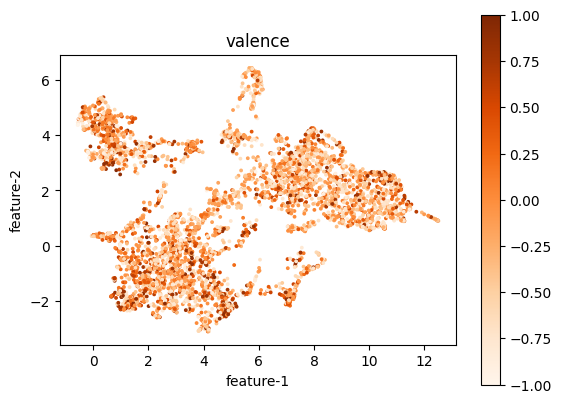

In [19]:
tokens, targets = CLE_tokens(non_finetuned_model,
                             feature_extractor,
                             val_dataset,
                             device)
non_finetuned_plot = plot_tokens(tokens, targets, 10)
wandb.log({'non-finetuned-plot': wandb.Image(non_finetuned_plot)})

In [20]:
wandb.finish()

eval/loss,8.15604
eval/mse,0.08539
eval/rmse,0.29221
eval/runtime,46.1619
eval/samples_per_second,97.483
eval/steps_per_second,6.109
train/epoch,0.6
train/global_step,6000
train/learning_rate,0.0
train/loss,6.4389
train/mse,0.01838
